In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def getThetaGD(X, y, n_iter=400, alpha=1, reg=0, activation=sigmoid):
    """find the solution (thetas) using the batch gradient descent"""
    m, n = X.shape
    theta = np.random.rand(n)
    Xt = X.transpose()
    for i in range(n_iter):
        h = activation(X @ theta)
        d_theta = Xt @ (h - y)
        d_theta[1:] += reg * theta[1:]
        d_theta /= m
        theta -= d_theta * alpha
    return theta

def getCostShanon(X, y, theta, reg=0, activation=sigmoid):
    """calculate the cost function as the Shanon entropy"""
    m = X.shape[0]
    h = activation(X @ theta)
    J = -y @ np.log(h) - (1 - y) @ np.log(1 - h)
    if reg != 0:
        J += reg * (theta[1:] ** 2).sum() / 2
    return J / m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


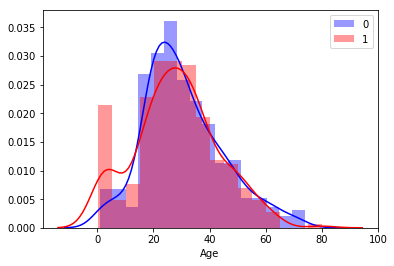

In [10]:
## data analysis
df = pd.read_csv("data/train.csv")
df.info()

## plotting
fig, fax = plt.subplots()
z = df[df["Survived"] == 0]["Age"]
sns.distplot(z[z.notna()], ax=fax, color="blue", label='0')
z = df[df["Survived"] == 1]["Age"]
sns.distplot(z[z.notna()], ax=fax, color="red", label='1')
plt.legend()

In [11]:
## input
df = pd.read_csv("data/train.csv")

## mapping strings to numbers
df["Sex"] = df["Sex"].replace({"male":0, "female":1})
df["Embarked"] = df["Embarked"].replace({'C':0, 'S':1, 'Q':2})

## handling names
title_dict = {"Mr.":0, "Mrs.":1, "Mme.":1, "Miss.":2, "Mlle.":2, "Master.":3, "Dr.":4, "Rev.": 5}
for i_row, row in df.iterrows():
    name_str = row["Name"]
    if not isinstance(name_str, str):
        break # break the loop if the names have already been replaced by ints
    df.loc[i_row,"Name"] = 6 # assign the default value at the begining
    for word in name_str.split():
        if word in title_dict.keys():
            df.loc[i_row,"Name"] = title_dict[word]
            break # break the loop if the key value has been found
        
## handling nans
df = df.drop(columns=["Cabin"])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

## get dummies
features = ["Pclass", "Name"]
for f in features:
    df = pd.concat([df.drop(columns=f), pd.get_dummies(df[f], prefix=f)], axis=1)

## creating input and output dataframes
yf = df["Survived"]
Xf = df.drop(columns=["PassengerId", "Survived", "Ticket"])
Xf.insert(0, "cst", 1)

## normalizing
features = ["Age", "Fare"]
Xf[features] = (Xf[features] - Xf[features].mean()) / Xf[features].std()
print(Xf.head())

   cst  Sex       Age  SibSp  Parch      Fare  Embarked  Pclass_1  Pclass_2  \
0    1    0 -0.565419      1      0 -0.502163       1.0         0         0   
1    1    1  0.663488      1      0  0.786404       0.0         1         0   
2    1    1 -0.258192      0      0 -0.488580       1.0         0         0   
3    1    1  0.433068      1      0  0.420494       1.0         1         0   
4    1    0  0.433068      0      0 -0.486064       1.0         0         0   

   Pclass_3  Name_0  Name_1  Name_2  Name_3  Name_4  Name_5  Name_6  
0         1       1       0       0       0       0       0       0  
1         0       0       1       0       0       0       0       0  
2         1       0       0       1       0       0       0       0  
3         0       0       1       0       0       0       0       0  
4         1       1       0       0       0       0       0       0  


In [13]:
activation = sigmoid
n_iter = 2000
alpha = 0.25
reg = 1
frac_train = 0.75
m, n = Xf.shape
m1_arr = np.arange(5, m, 5)
score_train_arr, score_test_arr = [], []

for m1 in m1_arr:
    print("\r{0} out of {1}".format(m1, m), end='\r')
    # randomly choosing samples
    row_sampler = np.random.choice(m, m1, replace=False)
    ynp_m1 = yf.loc[row_sampler].to_numpy()
    Xnp_m1 = Xf.loc[row_sampler, :].to_numpy()
    # splitting into train and test
    m1_train = int(m1 * frac_train)
    ynp_m1_train = ynp_m1[:m1_train]
    Xnp_m1_train = Xnp_m1[:m1_train, :]
    ynp_m1_test = ynp_m1[m1_train:m1]
    Xnp_m1_test = Xnp_m1[m1_train:m1, :]
    # training
    theta = getThetaGD(Xnp_m1_train, ynp_m1_train, n_iter, alpha, reg)
    # evaluating
    score_train_arr.append(getCostShanon(Xnp_m1_train, ynp_m1_train, theta, reg))
    score_test_arr.append(getCostShanon(Xnp_m1_test, ynp_m1_test, theta, reg))

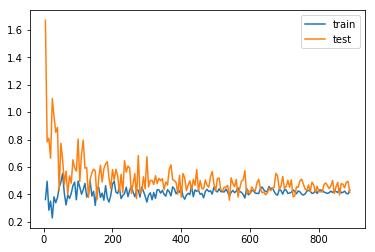

Final accuracy 0.8475336322869955


In [14]:
from sklearn.metrics import accuracy_score, f1_score
fig, fax = plt.subplots()
fax.plot(m1_arr, score_train_arr, label="train")
fax.plot(m1_arr, score_test_arr, label="test")
plt.legend()
plt.show()
ynp_m1_test_exp = activation(Xnp_m1_test @ theta) >= 0.5
print("Final accuracy", accuracy_score(ynp_m1_test_exp, ynp_m1_test))